# Comparing test-statistics: T-Test and Wilcoxon rank sum test for generic Zero-Inflated Negative Binomial  Distribution

In [1]:
import numpy as np
import scanpy.api as sc
from scanpy.data_structs.ann_data import AnnData
from numpy.random import negative_binomial, binomial, seed

/home/tobias/miniconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


First, data following a (zero-inflated) negative binomial (ZINB) distribution is created for testing purposes. Test size and distribution parameters can be specified.
For a specified number of marker genes in a cluster, distribution of these genes follows a different ZINB distribution. We use the following notation:

$z_r=\text{zero-inflation reference group}$

$z_c=\text{zero-inflation cluster}$

$p_r=\text{success probability reference group}$

$p_c=\text{success probability cluster}$

$n_r=\text{number of successfull draws till stop reference group}$

$n_c=\text{number of successfull draws till stop cluster}$

Let $X_r\sim NegBin(p_r,n_r)$, $Y_r\sim Ber(z_r)$ independent of $X$, then $Z_r=YX\sim ZINB(z_r,p_r,n_r)$ describes the distribution for the all cells/genes except for marker genes in a specified number of clustered cells, which are described using a $ZINB(z_c,p_c,n_c)$ distribution. 

Especially, we have 

$$\mathbb{E}[Z_r]=z_r*n_r*\frac{1-p_r}{p_r}$$

and using standard calculations for expectations and variance, 

$$\mathbb{V}[Z_r]=z_r*n_r\frac{1-p_r}{p_r²}+z_r(1-z_r)(n_r\frac{1-p_r}{p_r})²$$


This form of the ZINB was taken from

https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1293115 (Greene, 1994)


## Tune parameters and create data

In order to demonstrate the superiority of the wilcoxon rank test in certain cases, parameter specifications have to be found that violate the t-test assumptions and therefore make it difficult to detect marker genes. In short: Expectations should be the same, but variance should be different. 

The effect should increase with the magnitude of variance difference, as demonstrated below.
In order for the t-test to fail, little  to no difference in mean should occur. This can be achieved by tuning the parameters using the formula for expectation specified above. 

In [2]:
seed(1234)
# n_cluster needs to be smaller than n_simulated_cells, n_marker_genes needs to be smaller than n_simulated_genes
n_simulated_cells=1000
n_simulated_genes=100
n_cluster=100
n_marker_genes=10
# Specify parameter between 0 and 1 for zero_inflation and p, positive integer for r
# Differential gene expression is simulated using reference parameters for all cells/genes 
# except for marker genes in the distinct cells. 
reference_zero_inflation=0.15
reference_p=0.25
reference_n=2
cluster_zero_inflation=0.9
cluster_p=0.5
cluster_n=1

Create data.
Both sample names and variable names are simply intgers starting from 0. 


In [3]:
adata=AnnData(np.multiply(binomial(1,reference_zero_inflation,(n_simulated_cells,n_simulated_genes)),
                          negative_binomial(reference_n,reference_p,(n_simulated_cells,n_simulated_genes))))
# adapt marker_genes for cluster 
adata.X[0:n_cluster,0:n_marker_genes]=np.multiply(binomial(1,cluster_zero_inflation,(n_cluster,n_marker_genes)),
                                                  negative_binomial(cluster_n,cluster_p,(n_cluster,n_marker_genes)))

## Cluster according to true grouping: 


The following code includes the true grouping such that it can be accessed by normal function calling of 

    sc.tl.rank_genes_groups(adata,'true_groups')
    
or, respectively,

    sc.tl.rank_genes_groups(adata,'true_groups', test_type='wilcoxon')

In [4]:
smp='true_groups'
true_groups=np.zeros((2,n_simulated_cells),dtype=bool)
true_groups[0,0:n_cluster]=1
true_groups[1,n_cluster:n_simulated_cells]=1
adata.add[smp + '_masks']=true_groups
adata.add[smp + '_order']=np.asarray(['0','1'])

## Testing

### Case 1: No mean difference, large variance difference. 

Using the data created above, we get the following expectation and variance 

$\mathbb{E}[Z_r]=\mathbb{E}[Z_c]=0.9$

$\mathbb{V}[Z_r]=8.19$

$\mathbb{V}[Z_c]=1.89$



In [5]:
sc.tl.rank_genes_groups(adata, 'true_groups')

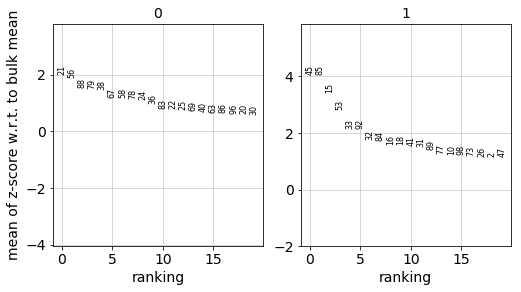

In [6]:
sc.pl.rank_genes_groups(adata, n_genes=20)

In [7]:
sc.tl.rank_genes_groups(adata, 'true_groups', test_type='wilcoxon')

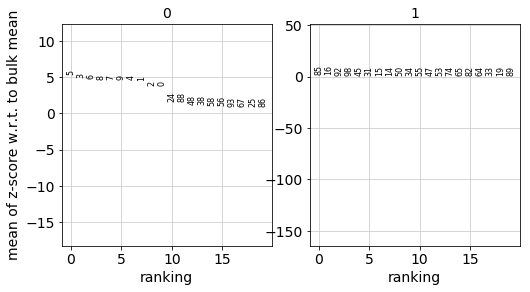

In [8]:
sc.pl.rank_genes_groups(adata, n_genes=20)

### Case 2: No mean difference, smaller variance difference

In [9]:
# n_cluster needs to be smaller than n_simulated_cells, n_marker_genes needs to be smaller than n_simulated_genes
n_simulated_cells=1000
n_simulated_genes=100
n_cluster=100
n_marker_genes=10
# Specify parameter between 0 and 1 for zero_inflation and p, positive integer for r
# Differential gene expression is simulated using reference parameters for all cells/genes 
# except for marker genes in the distinct cells. 
reference_zero_inflation=0.15
reference_p=0.5
reference_n=6
cluster_zero_inflation=0.9
cluster_p=0.5
cluster_n=1

This parameter initialization leads to the following expectations/ variances: 

$\mathbb{E}[Z_r]=\mathbb{E}[Z_c]=0.9$

$\mathbb{V}[Z_r]=6.39$

$\mathbb{V}[Z_c]=1.89$


In [10]:
adata=AnnData(np.multiply(binomial(1,reference_zero_inflation,(n_simulated_cells,n_simulated_genes)),
                          negative_binomial(reference_n,reference_p,(n_simulated_cells,n_simulated_genes))))
# adapt marker_genes for cluster 
adata.X[0:n_cluster,0:n_marker_genes]=np.multiply(binomial(1,cluster_zero_inflation,(n_cluster,n_marker_genes)),
                                                  negative_binomial(cluster_n,cluster_p,(n_cluster,n_marker_genes)))

In [11]:
smp='true_groups'
true_groups=np.zeros((2,n_simulated_cells),dtype=bool)
true_groups[0,0:n_cluster]=1
true_groups[1,n_cluster:n_simulated_cells]=1
adata.add[smp + '_masks']=true_groups
adata.add[smp + '_order']=np.asarray(['0','1'])

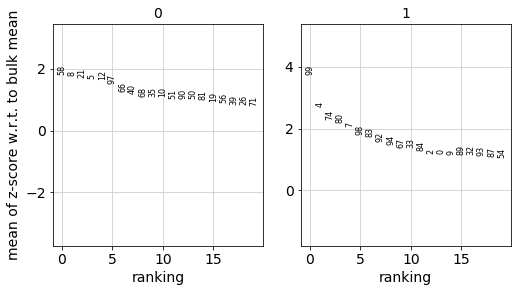

In [12]:
sc.tl.rank_genes_groups(adata, 'true_groups')
sc.pl.rank_genes_groups(adata, n_genes=20)

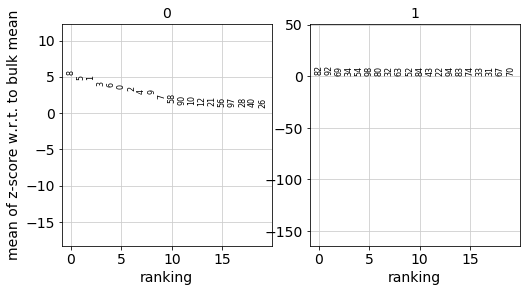

In [13]:
sc.tl.rank_genes_groups(adata, 'true_groups', test_type='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=20)